In [272]:
import yfinance as yf
import pandas as pd

# 定义获取数据的函数
def get_shanghai_index_data(start_date, end_date, interval="1h"):
    # Yahoo Finance 的上证指数代码是 '000001.SS'
    ticker = "000001.SS"
    
    # 获取数据
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    
    # 检查数据是否成功获取
    if not data.empty:
        print("成功获取数据！")
                # 将时间转换为北京时间
        data.index = pd.to_datetime(data.index)
        data.index = data.index.tz_convert("Asia/Shanghai")
        return data
    else:
        print("未获取到数据，可能需要检查代码或数据源。")
        return None

# 设置时间范围
start_date = "2023-12-31"
end_date = "2024-01-26"  # 包含结束日期
interval = "1h"  # 每小时数据

# 获取上证指数每小时数据
data = get_shanghai_index_data(start_date, end_date, interval)

# 如果数据不为空，则保存为CSV文件
if data is not None:
    data.to_csv("shanghai_index_hourly.csv")
    print("数据已保存到 shanghai_index_hourly.csv")


[*********************100%***********************]  1 of 1 completed

成功获取数据！
数据已保存到 shanghai_index_hourly.csv


In [273]:
import pandas as pd
from datetime import datetime
from joblib import Parallel, delayed
import re
from snownlp import SnowNLP
stock_data= pd.read_csv("shanghai_index_hourly.csv")
sentiment_data = pd.read_csv("hourly_sentiment_combined.csv")
sentiment_data['variability_rate'] = sentiment_data['sentiment_index'].pct_change() * 100
surge_threshold = 50  # Adjust as needed
sentiment_data ['sudden_surge'] = sentiment_data ['variability_rate'] > surge_threshold
# 删除前两行
stock_data = stock_data.iloc[2:].reset_index(drop=True)

# 重命名列
stock_data.rename(columns={"Price": "Datetime"}, inplace=True)
stock_data.head()

,Datetime,Adj Close,Close,High,Low,Open,Volume
0,2024-01-02 09:30:00+08:00,2970.973876953125,2970.973876953125,2976.268310546875,2966.139892578125,2972.592041015625,970913712
1,2024-01-02 10:30:00+08:00,2968.49462890625,2968.49462890625,2973.030517578125,2965.264892578125,2971.413818359375,530590504
2,2024-01-02 11:30:00+08:00,2968.697998046875,2968.697998046875,2968.697998046875,2968.4326171875,2968.5595703125,16141200
3,2024-01-02 12:30:00+08:00,2972.71142578125,2972.71142578125,2973.419677734375,2968.08740234375,2968.716552734375,0
4,2024-01-02 13:30:00+08:00,2966.58740234375,2966.58740234375,2973.029541015625,2965.599853515625,2973.029541015625,768907904


In [274]:
import pandas as pd
from datetime import datetime
stock_data["Datetime"] = pd.to_datetime(stock_data["Datetime"])
sentiment_data["date_hour"] = pd.to_datetime(sentiment_data["date_hour"], format="%Y-%m-%d %H")
# 将股票数据按小时分组
stock_data["date_hour"] = stock_data["Datetime"].dt.floor("H")
# 为没有时区信息的列添加时区

sentiment_data["date_hour"] = sentiment_data["date_hour"].dt.tz_localize('UTC').dt.tz_convert("Asia/Shanghai")

combined_data = pd.merge(sentiment_data, stock_data, on="date_hour", how="inner")

combined_data


,date_hour,sentiment_index,variability_rate,sudden_surge,Datetime,Adj Close,Close,High,Low,Open,Volume
0,2024-01-02 09:00:00+08:00,0.541469,-27.920881,False,2024-01-02 09:30:00+08:00,2970.973876953125,2970.973876953125,2976.268310546875,2966.139892578125,2972.592041015625,970913712
1,2024-01-02 10:00:00+08:00,0.724912,33.878689,False,2024-01-02 10:30:00+08:00,2968.49462890625,2968.49462890625,2973.030517578125,2965.264892578125,2971.413818359375,530590504
2,2024-01-02 11:00:00+08:00,0.787789,8.673758,False,2024-01-02 11:30:00+08:00,2968.697998046875,2968.697998046875,2968.697998046875,2968.4326171875,2968.5595703125,16141200
3,2024-01-02 12:00:00+08:00,0.610604,-22.491376,False,2024-01-02 12:30:00+08:00,2972.71142578125,2972.71142578125,2973.419677734375,2968.08740234375,2968.716552734375,0
4,2024-01-02 13:00:00+08:00,0.615789,0.849080,False,2024-01-02 13:30:00+08:00,2966.58740234375,2966.58740234375,2973.029541015625,2965.599853515625,2973.029541015625,768907904
...,...,...,...,...,...,...,...,...,...,...,...
103,2024-01-25 10:00:00+08:00,0.535438,-21.466911,False,2024-01-25 10:30:00+08:00,2878.682373046875,2878.682373046875,2881.65673828125,2860.63720703125,2866.1962890625,0
104,2024-01-25 11:00:00+08:00,0.646318,20.708215,False,2024-01-25 11:30:00+08:00,2878.8251953125,2878.8251953125,2879.065185546875,2878.8251953125,2878.906982421875,32425000
105,2024-01-25 12:00:00+08:00,0.792020,22.543370,False,2024-01-25 12:30:00+08:00,2893.826904296875,2893.826904296875,2897.25244140625,2878.814697265625,2879.582763671875,516495404
106,2024-01-25 13:00:00+08:00,0.689693,-12.919732,False,2024-01-25 13:30:00+08:00,2901.434814453125,2901.434814453125,2904.7373046875,2885.34521484375,2893.928955078125,0


In [275]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
data = combined_data
# 创建下一小时的目标值
data['Close'] =data['Close'].astype('float')
data['next_close'] = data['Close'].shift(-1)  # 下一小时的收盘价作为目标
data = data.dropna()  # 删除缺失值行

# 特征和目标
X = data[['sentiment_index', 'variability_rate', 'sudden_surge','Close']]
#X = data[['sentiment_index', 'Close']]
y = data['next_close']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 训练随机森林模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 960.3661006460966


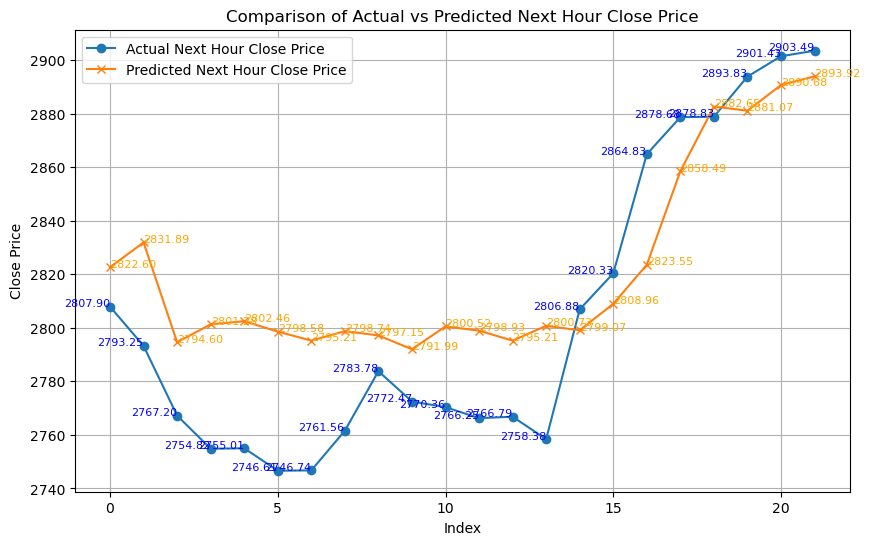

In [276]:
import matplotlib.pyplot as plt
import numpy as np

# 转换 y_test 为浮点数
y_test = y_test.astype(float)

# 创建一个范围索引
x_range = range(len(y_test))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y_test, label="Actual Next Hour Close Price", marker='o')
plt.plot(x_range, y_pred, label="Predicted Next Hour Close Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y_test, y_pred)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Hour Close Price")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [277]:
from sklearn.ensemble import GradientBoostingRegressor

# 训练梯度提升回归模型
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train, y_train)

# 预测
y_pred_gbr = gbr_model.predict(X_test)

# 评估
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f"Gradient Boosting Regressor Mean Squared Error: {mse_gbr}")



Gradient Boosting Regressor Mean Squared Error: 875.2163058204459


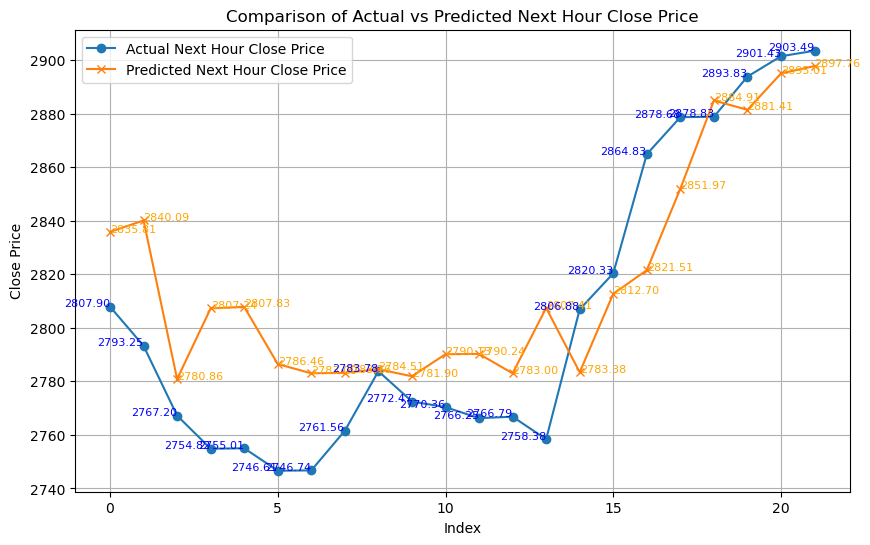

In [278]:
import matplotlib.pyplot as plt
import numpy as np

# 转换 y_test 为浮点数
y_test = y_test.astype(float)

# 创建一个范围索引
x_range = range(len(y_test))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y_test, label="Actual Next Hour Close Price", marker='o')
plt.plot(x_range, y_pred_gbr, label="Predicted Next Hour Close Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y_test, y_pred_gbr)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Hour Close Price")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [279]:
from sklearn.neural_network import MLPRegressor

# 训练 MLP 回归模型
mlp_model = MLPRegressor(hidden_layer_sizes=(15, 15), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# 预测
y_pred_mlp = mlp_model.predict(X_test)

# 评估
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
print(f"MLP Regressor Mean Squared Error: {mse_mlp}")




MLP Regressor Mean Squared Error: 303.94449285126205


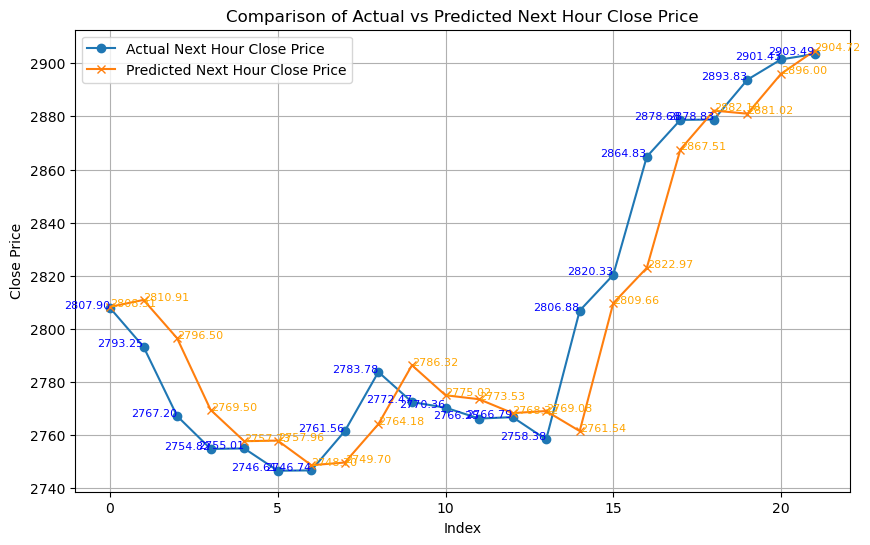

In [280]:
import matplotlib.pyplot as plt
import numpy as np

# 转换 y_test 为浮点数
y_test = y_test.astype(float)

# 创建一个范围索引
x_range = range(len(y_test))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y_test, label="Actual Next Hour Close Price", marker='o')
plt.plot(x_range, y_pred_mlp, label="Predicted Next Hour Close Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y_test, y_pred_mlp)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Hour Close Price")
plt.xlabel("Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [281]:
missing_data = sentiment_data[~sentiment_data["date_hour"].isin(combined_data["date_hour"])]

missing_data["date"] = missing_data["date_hour"].dt.date
daily_sentiment = missing_data.groupby("date")["sentiment_index"].mean().reset_index()

daily_sentiment.rename(columns={"sentiment_index": "daily_sentiment"}, inplace=True)

/var/folders/fr/b89hs77151gghnm7tj1sm3_w0000gn/T/ipykernel_28568/1305619836.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_data["date"] = missing_data["date_hour"].dt.date


In [282]:
import yfinance as yf
import pandas as pd

# 定义获取数据的函数
def get_shanghai_index_data(start_date, end_date, interval="1d"):
    # Yahoo Finance 的上证指数代码是 '000001.SS'
    ticker = "000001.SS"
    
    # 获取数据
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    
    # 检查数据是否成功获取
    if not data.empty:
        print("成功获取数据！")
                # 将时间转换为北京时间
        data.index = pd.to_datetime(data.index)
        data.index = data.index.tz_localize("UTC").tz_convert("Asia/Shanghai")
        return data
    else:
        print("未获取到数据，可能需要检查代码或数据源。")
        return None

# 设置时间范围
start_date = "2023-12-31"
end_date = "2024-01-26"  # 包含结束日期
interval = "1d"  # 每小时数据

# 获取上证指数每小时数据
daily_data = get_shanghai_index_data(start_date, end_date, interval)
daily_data.to_csv("daily_stock_data")

[*********************100%***********************]  1 of 1 completed

成功获取数据！


In [283]:
daily_data = pd.read_csv("daily_stock_data")
daily_data =daily_data.iloc[2:].reset_index(drop=True)
daily_data.rename(columns={"Price": "Datetime"}, inplace=True)

In [284]:
daily_sentiment['Datetime'] =pd.to_datetime(daily_sentiment["date"], format="%Y-%m-%d")
daily_data['Datetime'] =pd.to_datetime(daily_data["Datetime"], format="%Y-%m-%d")

daily_sentiment['Datetime'] = daily_sentiment['Datetime'].dt.tz_localize('UTC').dt.tz_convert("Asia/Shanghai")
daily_data['Datetime'] = daily_data['Datetime'].dt.tz_convert("Asia/Shanghai")

In [285]:
merged_df = pd.merge(daily_data, daily_sentiment, on='Datetime', how='inner')


In [286]:
# 移位 daily_sentiment
merged_df['prev_daily_sentiment'] = merged_df['daily_sentiment'].shift(1)

# 删除第一行无效数据
predict_df = merged_df.dropna(subset=['prev_daily_sentiment'])

# 构建预测数据集
predict_data = predict_df[['prev_daily_sentiment', 'Open']]


In [287]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 移位 daily_sentiment
merged_df['prev_daily_sentiment'] = merged_df['daily_sentiment'].shift(1)

# 删除第一行无效数据
predict_df = merged_df.dropna(subset=['prev_daily_sentiment'])

# 特征和目标变量
X = predict_df[['prev_daily_sentiment']]
y = predict_df['Open']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 初始化模型
linear_model = LinearRegression()
linear_model.fit(X, y)

# 预测
linear_pred = linear_model.predict(X)

# 评估
mae = mean_absolute_error(y, linear_pred)
mse = mean_squared_error(y, linear_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, linear_pred)

print("Linear Regression Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")



Linear Regression Performance:
MAE: 45.30, MSE: 3315.63, RMSE: 57.58, R2: 0.02


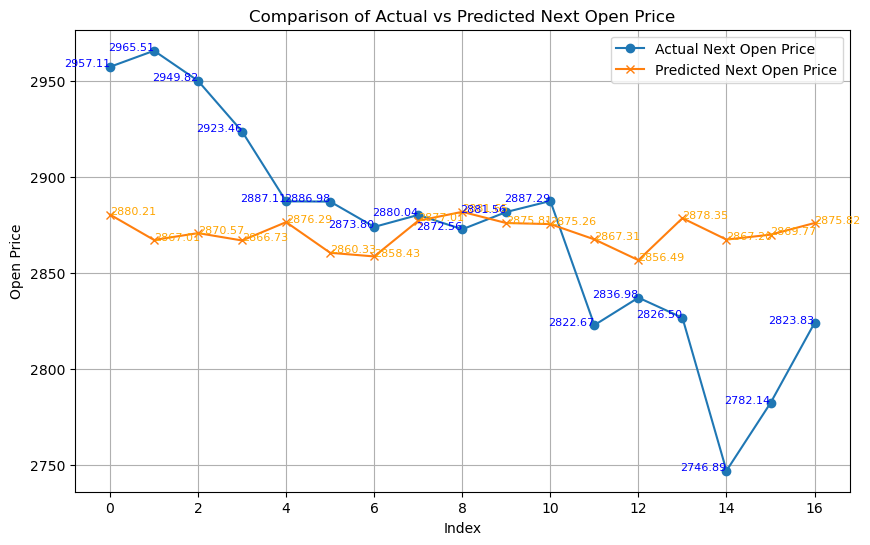

In [288]:
import matplotlib.pyplot as plt
import numpy as np


y= y.astype(float)

# 创建一个范围索引
x_range = range(len(y))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y, label="Actual Next Open Price", marker='o')
plt.plot(x_range, linear_pred, label="Predicted Next Open Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y, linear_pred)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Open Price")
plt.xlabel("Index")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.show()

In [289]:
from sklearn.ensemble import RandomForestRegressor

# 初始化模型
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X, y)

# 预测
rf_pred = rf_model.predict(X)

# 评估
mae = mean_absolute_error(y, rf_pred)
mse = mean_squared_error(y, rf_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, rf_pred)

print("Random Forest Regressor Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f},RMSE: {rmse:.2f}, R2: {r2:.2f}")


Random Forest Regressor Performance:
MAE: 23.50, MSE: 1028.80,RMSE: 32.07, R2: 0.69


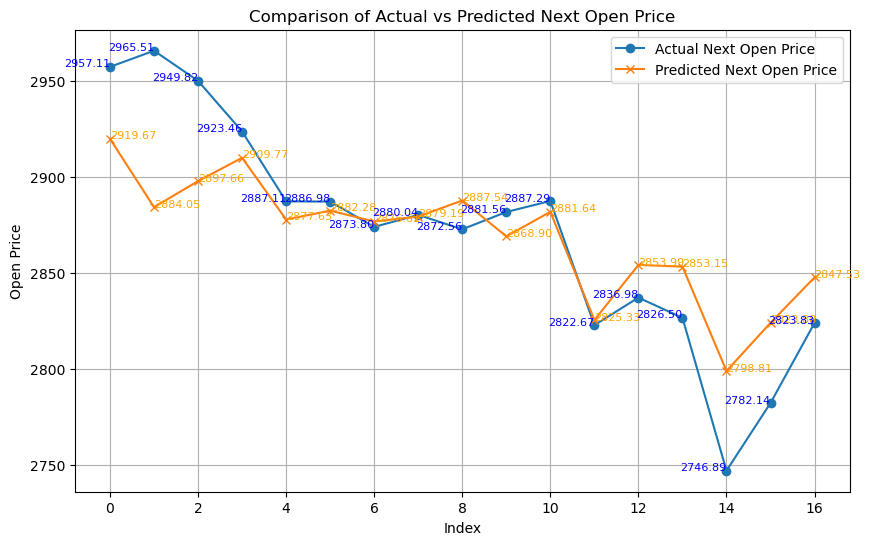

In [290]:
import matplotlib.pyplot as plt
import numpy as np


y= y.astype(float)

# 创建一个范围索引
x_range = range(len(y))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y, label="Actual Next Open Price", marker='o')
plt.plot(x_range, rf_pred, label="Predicted Next Open Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y, rf_pred)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Open Price")
plt.xlabel("Index")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.show()

In [291]:
from sklearn.svm import SVR

# 初始化模型
svr_model = SVR(kernel='rbf')
svr_model.fit(X, y)

# 预测
svr_pred = svr_model.predict(X)

# 评估
mae = mean_absolute_error(y, svr_pred)
mse = mean_squared_error(y, svr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, svr_pred)

print("Support Vector Regression Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f},RMSE: {rmse:.2f}, R2: {r2:.2f}")


Support Vector Regression Performance:
MAE: 44.12, MSE: 3441.30,RMSE: 58.66, R2: -0.02


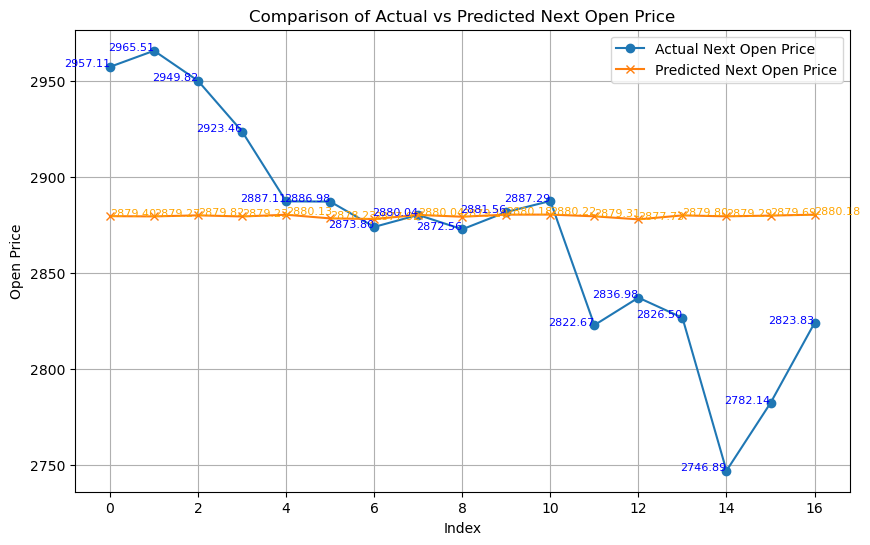

In [292]:
import matplotlib.pyplot as plt
import numpy as np

# 转换 y_test 为浮点数
y = y.astype(float)

# 创建一个范围索引
x_range = range(len(y))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y, label="Actual Next Open Price", marker='o')
plt.plot(x_range, svr_pred, label="Predicted Next Open Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y, svr_pred)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Open Price")
plt.xlabel("Index")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.show()

In [293]:
from sklearn.ensemble import GradientBoostingRegressor

# 初始化模型
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

# 预测
gb_pred = gb_model.predict(X)

# 评估
mae = mean_absolute_error(y, gb_pred)
mse = mean_squared_error(y, gb_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, gb_pred)

print("Gradient Boosting Regressor Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")


Gradient Boosting Regressor Performance:
MAE: 1.11, MSE: 1.93, RMSE: 1.39, R2: 1.00


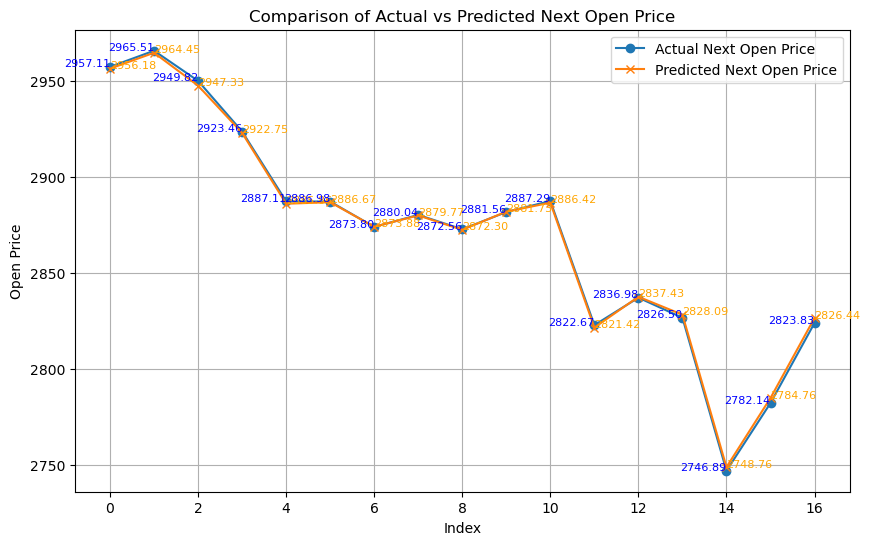

In [294]:
import matplotlib.pyplot as plt
import numpy as np

# 转换 y_test 为浮点数
y = y.astype(float)

# 创建一个范围索引
x_range = range(len(y))

# 可视化实际值和预测值
plt.figure(figsize=(10, 6))
plt.plot(x_range, y, label="Actual Next Open Price", marker='o')
plt.plot(x_range, gb_pred, label="Predicted Next Open Price", marker='x')

# 添加误差条目
for i, (true, pred) in enumerate(zip(y, gb_pred)):
    plt.text(i, true, f"{true:.2f}", ha="right", fontsize=8, color="blue")
    plt.text(i, pred, f"{pred:.2f}", ha="left", fontsize=8, color="orange")

# 图表美化
plt.title("Comparison of Actual vs Predicted Next Open Price")
plt.xlabel("Index")
plt.ylabel("Open Price")
plt.legend()
plt.grid(True)
plt.show()